# Imports


In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [3]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


# Loading Training Data

In [4]:
# Load data from CSV files
# file_paths = [
#                 'cleaned_scored_reviews_tt0111161.csv',
#                 'cleaned_scored_reviews_tt0468569.csv',
#                 'cleaned_scored_reviews_tt15398776.csv'
#              ]
# dfs = [pd.read_csv(file) for file in file_paths]
# df = pd.concat(dfs, ignore_index=True)
df = pd.read_csv('vader_dbert_scored.csv')
df = df[df['Review'].notna()]
df = df[df['Sentiment_Score'].notna()]

In [5]:
df.head()

,Unnamed: 0,Title,Author,Date,Stars(out_of_10),Review,VADER_Sentiment_Score,BERT_Sentiment_Score,Sentiment_Score,Polarity
0,0,Some birds aren't meant to be caged.,hitchcockthelegend,24 July 2010,10.0,the shawshank redemption is written and direct...,0.9983,0.981635,0.989968,1
1,1,An incredible movie. One that lives with you.,Sleepin_Dragon,17 February 2021,10.0,it is no wonder that the film has such a high ...,0.9766,0.987899,0.982249,1
2,2,Don't Rent Shawshank.,EyeDunno,21 November 2005,10.0,im trying to save you money this is the last f...,0.9935,0.981112,0.987306,1
3,3,A classic piece of unforgettable film-making.,kaspen12,10 February 2006,10.0,in its oscar year shawshank redemption written...,0.9993,0.986902,0.993101,1
4,4,This is How Movies Should Be Made,alexkolokotronis,18 February 2008,10.0,this movie is not your ordinary hollywood flic...,0.9907,0.988410,0.989555,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24845 entries, 0 to 24844
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             24845 non-null  int64  
 1   Title                  24844 non-null  object 
 2   Author                 24845 non-null  object 
 3   Date                   24845 non-null  object 
 4   Stars(out_of_10)       23872 non-null  float64
 5   Review                 24845 non-null  object 
 6   VADER_Sentiment_Score  24845 non-null  float64
 7   BERT_Sentiment_Score   24845 non-null  float64
 8   Sentiment_Score        24845 non-null  float64
 9   Polarity               24845 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 1.9+ MB


# Splitting into Train-Test Datasets

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X = df['Review'].values
y = df['Polarity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
# Create DataFrames for train and test data
train_dataset = pd.DataFrame({'Review': X_train, 'Polarity': y_train})
test_dataset = pd.DataFrame({'Review': X_test, 'Polarity': y_test})

# Convert DataFrames to Hugging Face Datasets
train_data = datasets.Dataset.from_pandas(train_dataset)
test_data = datasets.Dataset.from_pandas(test_dataset)

# Print the datasets to verify
print("Train Dataset:")
print(train_data)
print("\nTest Dataset:")
print(test_data)

Train Dataset:
Dataset({
    features: ['Review', 'Polarity'],
    num_rows: 14907
})

Test Dataset:
Dataset({
    features: ['Review', 'Polarity'],
    num_rows: 9938
})


In [8]:
from torchtext.data import get_tokenizer

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [9]:
tokenizer = get_tokenizer("basic_english")

def tokenize_example(dataset, tokenizer, max_length):
    tokens = tokenizer(dataset['Review'])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [10]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/14907 [00:00<?, ? examples/s]

Map:   0%|          | 0/9938 [00:00<?, ? examples/s]

In [11]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [12]:
from torchtext.vocab import build_vocab_from_iterator

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [13]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [14]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [15]:
vocab.set_default_index(unk_index)

In [16]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [17]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/11180 [00:00<?, ? examples/s]

Map:   0%|          | 0/3727 [00:00<?, ? examples/s]

Map:   0%|          | 0/9938 [00:00<?, ? examples/s]

In [18]:
train_data

Dataset({
    features: ['Review', 'Polarity', 'tokens', 'length', 'ids'],
    num_rows: 11180
})

In [19]:
train_data = train_data.with_format(type="torch", columns=["ids", "Polarity", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "Polarity", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "Polarity", "length"])

In [20]:
train_data[0]

{'Polarity': tensor(1),
 'length': tensor(108),
 'ids': tensor([   8,  152,    9, 3085,  154,   17,    2,   40,    8,  662,  194,   49,
            7,  121,   37,   10, 3220,    3,  293,  477,    4,  434,   65,    6,
         1185,    5,  608,   37,  404,   19,    5,  863, 1407,   37, 1355,    3,
         5341,  114,    2,  680, 1593,   17, 1589,   33,   25,    2,  226,  760,
            2, 2065, 3809,   10,  585,   63, 1094,    7,  198,    2,  956,  771,
          284,  251,   48,   23,  969,   79,   99,    6,    5,   44, 1940,   17,
           27,    4,  150,    8, 3946,  266,  154,   13,   27,    0,    4,    2,
           50,  125,   28,  451,    4,   95,   49,    3,   49,    5,   44,  585,
            5,  284,  367,  828,   65, 3738,  920,   17, 1032,   45,   10,  424])}

In [21]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["Polarity"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "Polarity": batch_label}
        return batch

    return collate_fn

In [22]:
from torch.utils.data import DataLoader
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [23]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [57]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [137]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("Polarity"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [138]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,351,602 trainable parameters


In [139]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [140]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(9136, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [29]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:49, 5.31MB/s]                            
100%|█████████▉| 2196016/2196017 [04:52<00:00, 7516.99it/s]


In [141]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [142]:
model.embedding.weight.data = pretrained_embedding

In [143]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [144]:
criterion = nn.CrossEntropyLoss()

In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [146]:
model = model.to(device)
criterion = criterion.to(device)

In [147]:
def train_model(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["Polarity"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        precision, recall, f1 = get_metrics(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        epoch_precisions.append(precision)
        epoch_recalls.append(recall)
        epoch_f1s.append(f1)
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_precisions), np.mean(epoch_recalls), np.mean(epoch_f1s)

In [148]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["Polarity"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision, recall, f1 = get_metrics(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            epoch_precisions.append(precision)
            epoch_recalls.append(recall)
            epoch_f1s.append(f1)
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_precisions), np.mean(epoch_recalls), np.mean(epoch_f1s)

In [149]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [150]:
from sklearn.metrics import precision_recall_fscore_support
def get_metrics(prediction, label):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    true_classes = label.cpu().numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
    return precision, recall, f1

In [151]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_model(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["train_precisions"].append(train_precision)
    metrics["train_recalls"].append(train_recall)
    metrics["train_f1s"].append(train_f1)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    metrics["valid_precisions"].append(valid_precision)
    metrics["valid_recalls"].append(valid_recall)
    metrics["valid_f1s"].append(valid_f1)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm_final.pt")
    print(f"epoch: {epoch}")
    # print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    # print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, train_precision: {train_precision:.3f}, train_recall: {train_recall:.3f}, train_f1: {train_f1:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}, valid_precision: {valid_precision:.3f}, valid_recall: {valid_recall:.3f}, valid_f1: {valid_f1:.3f}")

training...:   9%|▉         | 2/22 [00:01<00:12,  1.63it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
training...:  14%|█▎        | 3/22 [00:01<00:11,  1.65it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
training...:  18%|█▊        | 4/22 [00:02<00:10,  1.67it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

epoch: 0
train_loss: 0.397, train_acc: 0.857, train_precision: 0.777, train_recall: 0.857, train_f1: 0.808
valid_loss: 0.342, valid_acc: 0.884, valid_precision: 0.782, valid_recall: 0.884, valid_f1: 0.830


training...:   0%|          | 0/22 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
training...:   5%|▍         | 1/22 [00:00<00:12,  1.67it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
training...:   9%|▉         | 2/22 [00:01<00:12,  1.64it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

epoch: 1
train_loss: 0.322, train_acc: 0.883, train_precision: 0.814, train_recall: 0.883, train_f1: 0.828
valid_loss: 0.298, valid_acc: 0.885, valid_precision: 0.835, valid_recall: 0.885, valid_f1: 0.837


training...:  91%|█████████ | 20/22 [00:12<00:01,  1.66it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
evaluating...: 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]


epoch: 2
train_loss: 0.295, train_acc: 0.891, train_precision: 0.874, train_recall: 0.891, train_f1: 0.859
valid_loss: 0.316, valid_acc: 0.886, valid_precision: 0.854, valid_recall: 0.886, valid_f1: 0.839


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]


epoch: 3
train_loss: 0.266, train_acc: 0.899, train_precision: 0.891, train_recall: 0.899, train_f1: 0.879
valid_loss: 0.293, valid_acc: 0.868, valid_precision: 0.863, valid_recall: 0.868, valid_f1: 0.865


training...:  95%|█████████▌| 21/22 [00:12<00:00,  1.67it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
evaluating...: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]


epoch: 4
train_loss: 0.267, train_acc: 0.887, train_precision: 0.878, train_recall: 0.887, train_f1: 0.861
valid_loss: 0.265, valid_acc: 0.886, valid_precision: 0.855, valid_recall: 0.886, valid_f1: 0.839


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


epoch: 5
train_loss: 0.249, train_acc: 0.899, train_precision: 0.892, train_recall: 0.899, train_f1: 0.880
valid_loss: 0.239, valid_acc: 0.907, valid_precision: 0.894, valid_recall: 0.907, valid_f1: 0.896


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]


epoch: 6
train_loss: 0.223, train_acc: 0.911, train_precision: 0.904, train_recall: 0.911, train_f1: 0.902
valid_loss: 0.255, valid_acc: 0.904, valid_precision: 0.891, valid_recall: 0.904, valid_f1: 0.884


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


epoch: 7
train_loss: 0.220, train_acc: 0.913, train_precision: 0.907, train_recall: 0.913, train_f1: 0.902
valid_loss: 0.215, valid_acc: 0.913, valid_precision: 0.903, valid_recall: 0.913, valid_f1: 0.902


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


epoch: 8
train_loss: 0.206, train_acc: 0.919, train_precision: 0.918, train_recall: 0.919, train_f1: 0.914
valid_loss: 0.206, valid_acc: 0.914, valid_precision: 0.908, valid_recall: 0.914, valid_f1: 0.910


evaluating...: 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

epoch: 9
train_loss: 0.176, train_acc: 0.929, train_precision: 0.927, train_recall: 0.929, train_f1: 0.927
valid_loss: 0.213, valid_acc: 0.920, valid_precision: 0.912, valid_recall: 0.920, valid_f1: 0.910


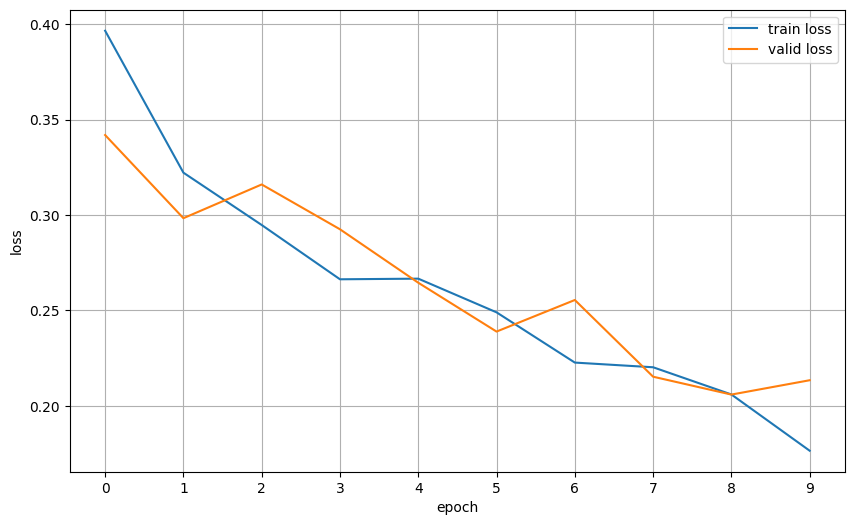

In [152]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

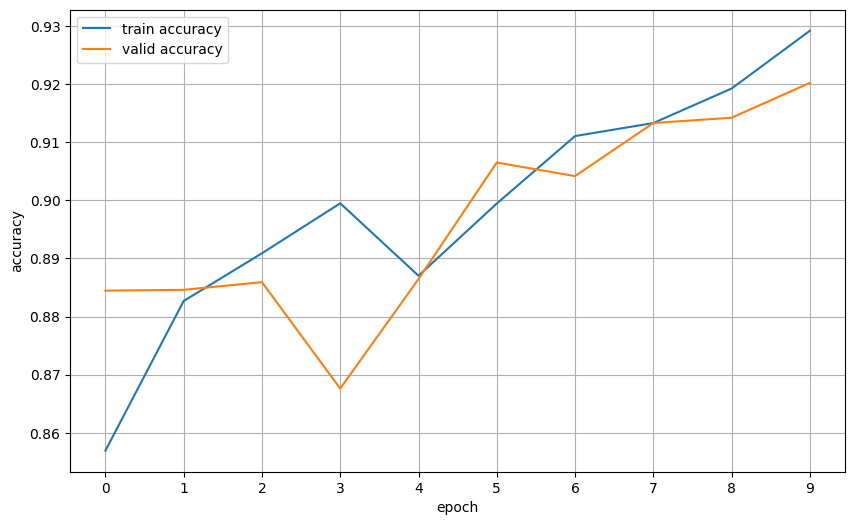

In [153]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [154]:
model.load_state_dict(torch.load("lstm_final.pt", map_location=torch.device('cpu')))

train_loss, train_acc, train_precision, train_recall, train_f1 = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


In [155]:
# print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

In [156]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    if(predicted_class == 1):
        return predicted_class, predicted_probability
    else:
        return predicted_class, -predicted_probability

In [157]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, -0.7262940406799316)

In [158]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9475852251052856)

In [159]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5459148287773132)

In [168]:
text = "This film is okay."

predict_sentiment(text, model, tokenizer, vocab, device)

(0, -0.5364739894866943)

# Testing on Dataset

In [161]:
plot_df = pd.read_csv('cleaned_scored_reviews_tt0455944.csv')

plot_df = plot_df[plot_df['Review'].notna()]
plot_df = plot_df[plot_df['Sentiment_Score'].notna()]

print(plot_df.head)

<bound method NDFrame.head of                                                  Title           Author  \
0                                   May the Blood Flow     Tweetienator   
1    Denzel Washington made this film better than i...  Top_Dawg_Critic   
2                                      Denzel nails it   Leofwine_draca   
3                 A Stylish And Daring Action Thriller          CalRhys   
4    Gruesome at times, The Equalizer is a rewardin...       LloydBayer   
..                                                 ...              ...   
771                                we are magpies now?    destinedsleep   
772     I liked this until he pulls out a Hilti DX 351    blackriverrt3   
773                  Quintessential Denzel Washington!            m1965   
774                      Silent, brooding and Kick-ass        Asurasura   
775                                    What about Bob?            sesht   

                  Date  Stars(out_of_10)  \
0          6 June 2019   

In [162]:
# Predict sentiment scores for all reviews
plot_df['Predicted_Polarity'] = plot_df['Review'].apply(lambda x: predict_sentiment(x, model, tokenizer, vocab, device)[0])
plot_df['Predicted_Sentiment_Score'] = plot_df['Review'].apply(lambda x: predict_sentiment(x, model, tokenizer, vocab, device)[1])



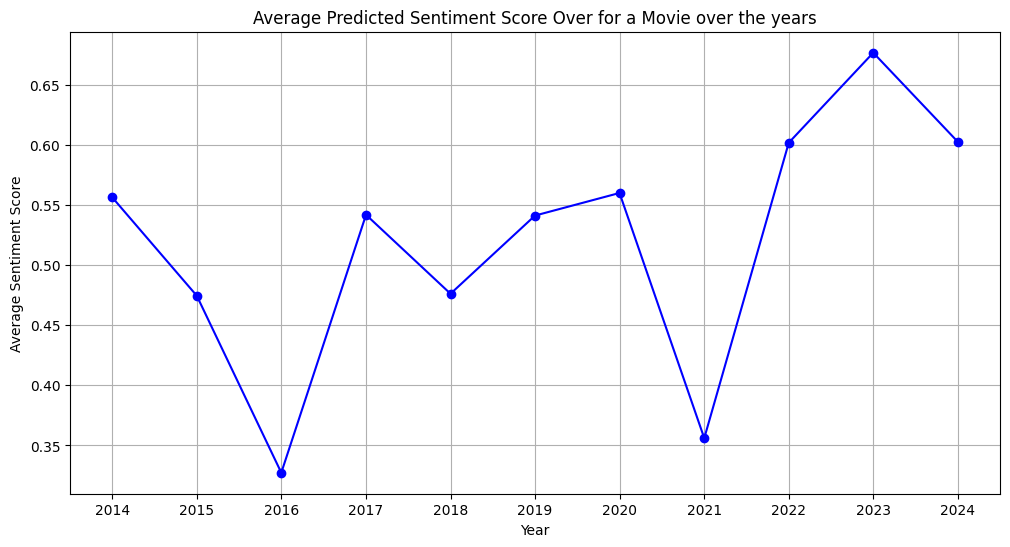

In [163]:
# Convert the 'Date' column to datetime format
plot_df['Date'] = pd.to_datetime(plot_df['Date'], format='%d %B %Y')

# Sort the dataframe by date
plot_df = plot_df.sort_values('Date')

# Extract year and month from the date
plot_df['YearMonth'] = plot_df['Date'].dt.to_period('Y')

# Calculate the average predicted probability for each month
monthly_avg = plot_df.groupby('YearMonth')['Predicted_Sentiment_Score'].mean().reset_index()
monthly_avg2 = plot_df.groupby('YearMonth')['Sentiment_Score'].mean().reset_index()

# Convert the 'YearMonth' column back to datetime for plotting
monthly_avg['YearMonth'] = monthly_avg['YearMonth'].dt.to_timestamp()
monthly_avg2['YearMonth'] = monthly_avg2['YearMonth'].dt.to_timestamp()

# Plot the average predicted sentiment scores for each month
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['YearMonth'], monthly_avg['Predicted_Sentiment_Score'], marker='o', linestyle='-', color='b')
# plt.plot(monthly_avg2['YearMonth'], monthly_avg2['Sentiment_Score'], marker='s', linestyle='-', color='g')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.title('Average Predicted Sentiment Score Over for a Movie over the years')
plt.grid(True)
plt.show()

In [165]:
torch.save(vocab, 'vocab.pth')

In [166]:
tokenizer

<function torchtext.data.utils._basic_english_normalize(line)>

In [167]:
len(vocab)

9136